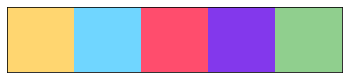

In [1]:
import os, tqdm, json, pickle, gc, zipfile, itertools, time, collections, sys, requests, schedule
import pandas as pd
import numpy as np
from dateutil import parser
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from collections import defaultdict
from datetime import datetime
from sklearn.model_selection import train_test_split
import catboost as cb
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, mean_squared_error
import catboost as cb
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.inspection import permutation_importance
from scipy import stats
from functools import reduce

import matplotlib.pyplot as plt
import seaborn as sns

custom_colors = ["#ffd670","#70d6ff","#ff4d6d","#8338ec","#90cf8e"]
customPalette = sns.set_palette(sns.color_palette(custom_colors))
sns.palplot(sns.color_palette(custom_colors),size=1.2)
plt.tick_params(axis='both', labelsize=0, length = 0)

def reduce_mem_usage(series):  
            
    col_type = series.dtype
    
    try:
        if (col_type != object):
            c_min = series.min()
            c_max = series.max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    series= series.astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    series= series.astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    series= series.astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    series= series.astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    series= series = series= series.astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    series= series.astype(np.float32)
                else:
                    series= series.astype(np.float64)
        else:
            pass
    except:
        pass
    
    return series

class CatBoostEvalMetricAMEX(object):
    
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):        
        return True

    def evaluate(self, approxes, target, weight):

        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        preds = np.array(approxes[0])
        target = np.array(target)

        score = self.amex_metric_numpy(target, preds)     

        return score, 0

    def amex_metric_numpy(self, y_true, y_pred):

        # count of positives and negatives
        n_pos = y_true.sum()
        n_neg = y_true.shape[0] - n_pos

        # sorting by descring prediction values
        indices = np.argsort(y_pred)[::-1]
        preds, target = y_pred[indices], y_true[indices]

        # filter the top 4% by cumulative row weights
        weight = 20.0 - target * 19.0
        cum_norm_weight = (weight / weight.sum()).cumsum()
        four_pct_filter = cum_norm_weight <= 0.04

        # default rate captured at 4%
        d = target[four_pct_filter].sum() / n_pos

        # weighted gini coefficient
        lorentz = (target / n_pos).cumsum()
        gini = ((lorentz - cum_norm_weight) * weight).sum()

        # max weighted gini coefficient
        gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

        # normalized weighted gini coefficient
        g = gini / gini_max

        return 0.5 * (g + d)

def amex_metric_official(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()

    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def get_metrics(model, X_eval, y_eval):

    """ calulate metrics """

    pred = model.predict(X_eval)
    pred_prob = model.predict_proba(X_eval)[:, 1]

    d= {}

    d['accuracy'] = accuracy_score(y_eval, pred)
    d['f1'] = f1_score(y_eval, pred)
    d['auc'] = roc_auc_score(y_eval, pred_prob)

    y_true, y_predprob = y_eval.to_frame('target'), pd.Series(pred_prob, index = y_eval.index).to_frame('prediction')
    d['amex_metric_official'] = amex_metric_official(y_true, y_predprob)

    d['tp'] = ((y_eval==1)&(pred==1)).sum()
    d['tn'] = ((y_eval==0)&(pred==0)).sum()
    d['fp'] = ((y_eval==0)&(pred==1)).sum()
    d['fn'] = ((y_eval==1)&(pred==0)).sum()

    d['importances'] = ser_imp = pd.Series(dict(zip(X_eval.columns, model.feature_importances_))).sort_values(ascending = False)

    return d

def eval_catboost(X_train, y_train, X_eval, y_eval, eval_metric, seed, verbose, od_wait, params):

    """ evaluate model """

    cat_features = np.where(X_train.dtypes=='category')[0]

    if params is not None:
        params_c = params.copy()
    else:
        params_c = {}   
        params_c['iterations'] = 100
    params_c['cat_features'] = cat_features
    params_c['od_type'] = 'Iter'
    params_c['od_wait'] = od_wait  
    params_c['random_state'] = seed
    params_c['eval_metric'] = eval_metric
    params_c['verbose'] = verbose

    model = cb.CatBoostClassifier(**params_c)
    model.fit(X_train, y_train, eval_set = (X_eval, y_eval))    
    best_iter = model.best_iteration_
    return model, best_iter, get_metrics(model, X_eval, y_eval) 

def get_catboost_eval_results(X_train, y_train, X_eval, y_eval):

    """ feature selection and eval results """

    i=1
    while True:

        print('> iter#{}. n_features: {}'.format(i, X_train.shape[1]))

        model, best_iter, d_eval_results = eval_catboost(X_train, y_train, X_eval, y_eval,verbose=1)

        mask = model.feature_importances_>0

        if np.all(mask):
            break
        else:
            best_features = X_train.columns[mask]
            X_train, X_eval = X_train[best_features], X_eval[best_features]
            i+=1
    i = 1       
    while True:

        L_perm_imp = []
        for _ in tqdm.tqdm(range(10)):
            d_perm_imp = permutation_importance(model, X_eval, y_eval, scoring='roc_auc', n_jobs=-1, n_repeats = 1, random_state = _)    
            L_perm_imp.append(d_perm_imp['importances_mean'])
        mean_perm_imp = np.c_[L_perm_imp].mean(0)

        mask = mean_perm_imp>0

        if np.all(mask):
            break
        else:
            best_features = X_train.columns[mask]
            X_train, X_eval = X_train[best_features], X_eval[best_features]
            model, best_iter, d_eval_results = eval_catboost(X_train, y_train, X_eval, y_eval,verbose=0)
            i+=1

    return {
        'iterations':best_iter,        
        'eval_results':d_eval_results
    }

def amex_metric_numpy(y_true, y_pred):

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

In [2]:
class CFG:

    # paths 
    PATH_TO_DATA = 'data'
    PATH_TO_TRAIN_DATA = os.path.join(PATH_TO_DATA,'train_data.ftr')
    PATH_TO_TEST_DATA = os.path.join(PATH_TO_DATA,'test_data.ftr')
    TRAIN_LABELS = os.path.join(PATH_TO_DATA,'train_labels.csv')
    SAMPLE_SUBMISSION = os.path.join(PATH_TO_DATA,'sample_submission.csv')
    SEED = 13
    TARGET_KEY= 'target'
    ID_KEY = 'customer_ID'
    PREDICTION_KEY= 'prediction'    
    DATE_KEY = 'S_2'
    PATH_OUT_TRAIN = 'train_data_out.pickle'
    PATH_OUT_TEST = 'test_data_out.pickle'   
    PATH_TO_FEATURES_TRAIN = 'features_train' 

    
    # batch size
    BATCH_SIZE = 1000
    # fill value
    DEFAULT_VALUE = -9999
    # split
    TEST_SIZE= .1
    
    # categories
    CAT_FEATURES = [
        'D_63', 'D_64', 'D_66', 'D_68', 'B_30', 'B_38', 'D_114', 'D_116',
        'D_117', 'D_120', 'D_126'
    ]

    # numbers
    NUM_FEATURES = [
        'P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42', 'D_43', 'D_44', 'B_4',
        'D_45', 'B_5', 'R_2', 'D_46', 'D_47', 'D_48', 'D_49', 'B_6', 'B_7', 'B_8', 'D_50', 'D_51',
        'B_9', 'R_3', 'D_52', 'P_3', 'B_10', 'D_53', 'S_5', 'B_11', 'S_6', 'D_54', 'R_4', 'S_7',
        'B_12', 'S_8', 'D_55', 'D_56', 'B_13', 'R_5', 'D_58', 'S_9', 'B_14', 'D_59', 'D_60',
        'D_61', 'B_15', 'S_11', 'D_62', 'D_65', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'S_12',
        'R_6', 'S_13', 'B_21', 'D_69', 'B_22', 'D_70', 'D_71', 'D_72', 'S_15', 'B_23', 'D_73', 'P_4',
        'D_74', 'D_75', 'D_76', 'B_24', 'R_7', 'D_77', 'B_25', 'B_26', 'D_78', 'D_79', 'R_8', 'R_9', 'S_16',
        'D_80', 'R_10', 'R_11', 'B_27', 'D_81', 'D_82', 'S_17', 'R_12', 'B_28', 'R_13', 'D_83', 'R_14',
        'R_15', 'D_84', 'R_16', 'B_29', 'S_18', 'D_86', 'D_87', 'R_17', 'R_18', 'D_88', 'B_31', 'S_19', 'R_19',
        'B_32', 'S_20', 'R_20', 'R_21', 'B_33', 'D_89', 'R_22', 'R_23', 'D_91', 'D_92', 'D_93', 'D_94', 'R_24',
        'R_25', 'D_96', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'D_102', 'D_103', 'D_104', 'D_105', 'D_106',
        'D_107',    'B_36', 'B_37', 'R_26', 'R_27', 'D_108', 'D_109', 'D_110', 'D_111', 'B_39', 'D_112', 'B_40',
        'S_27','D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 'D_128',
        'D_129', 'B_41', 'B_42', 'D_130', 'D_131', 'D_132', 'D_133', 'R_28', 'D_134', 'D_135', 'D_136', 'D_137',
        'D_138','D_139', 'D_140', 'D_141', 'D_142', 'D_143', 'D_144', 'D_145'
    ]

    TIME_FEATURES = ['timestamp', 'year']

    MAX_GROUP_SIZE = 13
    NUM_DIFF_FEATURES = []
    NUM_LAG_FEATURES = []

    for i in range(MAX_GROUP_SIZE-1):
        for key in NUM_FEATURES:
            NUM_DIFF_FEATURES.append(f'{key}__diff_{i+1}')
            NUM_LAG_FEATURES.append(f'{key}__lag_{i+1}')
    
    NUM_RANK_FEATURES = []
    for i in range(MAX_GROUP_SIZE):
        for key in NUM_FEATURES:        
            NUM_RANK_FEATURES.append(f'{key}__rank_{i+1}')


In [3]:
def load_data(CFG):

    # target
    y = pd.read_csv(CFG.TRAIN_LABELS).set_index(CFG.ID_KEY)[CFG.TARGET_KEY]

    # submission
    sample_submission = pd.read_csv(CFG.SAMPLE_SUBMISSION)

    # train data
    df_train = pd.read_feather(CFG.PATH_TO_TRAIN_DATA)
    df_train = df_train.set_index(CFG.ID_KEY).loc[y.index].reset_index()
    df_train_reduced= df_train.apply(reduce_mem_usage)
    del df_train
    gc.collect()
    df_train = df_train_reduced
    del df_train_reduced
    gc.collect()    

    # test data
    df_test = pd.read_feather(CFG.PATH_TO_TEST_DATA)
    df_test = df_test.set_index(CFG.ID_KEY)
    df_test_reduced = df_test.apply(reduce_mem_usage)
    del df_test
    gc.collect()
    df_test = df_test_reduced.reset_index()
    del df_test_reduced
    gc.collect()

    df_train['year'] = df_train[CFG.DATE_KEY].dt.year
    df_test['year'] = df_test[CFG.DATE_KEY].dt.year           

    return df_train, df_test, y, sample_submission

In [4]:
# load train and test data
df_train, df_test, y, sample_submission = load_data(CFG)

In [5]:
assert df_train.shape[1] == df_test.shape[1]+1

In [6]:
def clip_numbers(CFG, df_train, df_test, verbose):

    # series with target
    target = df_train[CFG.TARGET_KEY]

    # clip outliers
    for i, key in enumerate(CFG.NUM_FEATURES):
        
        ser= df_train[key]

        corr_abs = ser.to_frame().corrwith(target).abs().iloc[0]
        
        q1,q3=ser.quantile([.25,.95])
        iqr =q3-q1
        corr_abs_clipped= ser.clip(q1,q3).to_frame().corrwith(target).abs().iloc[0]

        if corr_abs_clipped>corr_abs:
            df_train[key]=df_train[key].clip(q1,q3)
            df_test[key]=df_test[key].clip(q1,q3)

            if verbose:
                print('ITER {}/{}. {} -> CLIPPED'.format(i+1, len(CFG.NUM_FEATURES), key))
        else:
            
            if verbose:
                print('ITER {}/{}. {} -> RAW'.format(i+1, len(CFG.NUM_FEATURES),key))

    return df_train, df_test

In [7]:
# clip
df_train, df_test = clip_numbers(CFG, df_train, df_test, verbose=True)

# export
df_train.to_pickle(CFG.PATH_OUT_TRAIN)
df_test.to_pickle(CFG.PATH_OUT_TEST)
del df_train, df_test
gc.collect()

ITER 1/177. P_2 -> RAW
ITER 2/177. D_39 -> RAW
ITER 3/177. B_1 -> CLIPPED
ITER 4/177. B_2 -> RAW
ITER 5/177. R_1 -> CLIPPED
ITER 6/177. S_3 -> CLIPPED
ITER 7/177. D_41 -> CLIPPED
ITER 8/177. B_3 -> CLIPPED
ITER 9/177. D_42 -> CLIPPED
ITER 10/177. D_43 -> CLIPPED
ITER 11/177. D_44 -> CLIPPED
ITER 12/177. B_4 -> CLIPPED
ITER 13/177. D_45 -> CLIPPED
ITER 14/177. B_5 -> CLIPPED
ITER 15/177. R_2 -> RAW
ITER 16/177. D_46 -> CLIPPED
ITER 17/177. D_47 -> RAW
ITER 18/177. D_48 -> CLIPPED
ITER 19/177. D_49 -> RAW
ITER 20/177. B_6 -> CLIPPED
ITER 21/177. B_7 -> CLIPPED
ITER 22/177. B_8 -> CLIPPED
ITER 23/177. D_50 -> CLIPPED
ITER 24/177. D_51 -> CLIPPED
ITER 25/177. B_9 -> CLIPPED
ITER 26/177. R_3 -> CLIPPED
ITER 27/177. D_52 -> CLIPPED
ITER 28/177. P_3 -> RAW
ITER 29/177. B_10 -> CLIPPED
ITER 30/177. D_53 -> CLIPPED
ITER 31/177. S_5 -> CLIPPED
ITER 32/177. B_11 -> CLIPPED
ITER 33/177. S_6 -> RAW
ITER 34/177. D_54 -> RAW
ITER 35/177. R_4 -> RAW
ITER 36/177. S_7 -> CLIPPED
ITER 37/177. B_12 -> CLI

In [3]:
df_train = pd.read_pickle(CFG.PATH_OUT_TRAIN)

In [9]:
def addNumeric_lag_diff_rank(CFG, df_train):

    # ADD DIFFERENCE, LAG FOR NUMERIC FEATURES
    # RANK EVERY NUMERIC FEATURE IN TIME BY VALUE

    # padding dataframe
    def add_rows(subdf, max_group_size, num_features):
        ''' pad data for customer to max records size'''
        size = subdf.shape[0]    
        df_add = pd.DataFrame(np.full((max_group_size-size, len(num_features)), np.nan), columns = num_features)    
        return df_add

    # customer_ID
    id_values = df_train[CFG.ID_KEY].unique()
    # customer batches
    batches = np.array_split(id_values, np.int32(np.ceil(len(id_values)/(CFG.BATCH_SIZE*10))))

    # aggregation numeric features in time
    num_in_time_agg = pd.DataFrame()

    # for each batch
    for batch in tqdm.tqdm_notebook(batches):

        # slice
        df_batch = df_train[df_train[CFG.ID_KEY].isin(batch)]

        # collection
        rows = []

        for id, subdf in tqdm.tqdm_notebook(df_batch.groupby(CFG.ID_KEY)):

            # features
            d = {CFG.ID_KEY:id}

            # padding history
            subdf_pad = pd.concat([
                add_rows(subdf, CFG.MAX_GROUP_SIZE, CFG.NUM_FEATURES),
                subdf[CFG.NUM_FEATURES]
            ])
            
            # rank every column
            arr_pad_ordered = pd.DataFrame(
                np.sort(subdf_pad.values, axis=0),
                index=subdf_pad.index,
                columns=subdf_pad.columns
            ).fillna(CFG.DEFAULT_VALUE).values.flatten()
            # diff
            arr_diff = subdf_pad.diff(1).iloc[1:].values.flatten()    
            # shift        
            arr_shift = subdf_pad.shift(1).iloc[1:].values.flatten()

            d.update(dict(zip(CFG.NUM_RANK_FEATURES, arr_pad_ordered)))
            d.update(dict(zip(CFG.NUM_LAG_FEATURES, arr_shift)))
            d.update(dict(zip(CFG.NUM_DIFF_FEATURES, arr_diff)))
            
            # collect
            rows.append(d)        
            del d, subdf_pad

        # to dataframe
        subdf_time_agg = pd.DataFrame.from_records(rows).replace({CFG.DEFAULT_VALUE:np.nan})
        del rows
        
        # reduce memory usage
        subdf_time_agg_reduced = subdf_time_agg.apply(reduce_mem_usage)
        del subdf_time_agg 

        # update
        num_in_time_agg = num_in_time_agg.append(subdf_time_agg_reduced)
        del subdf_time_agg_reduced 

    return num_in_time_agg

In [10]:
num_in_time_agg = addNumeric_lag_diff_rank(CFG, df_train)

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

In [11]:
num_in_time_agg.head()

,customer_ID,P_2__rank_1,D_39__rank_1,B_1__rank_1,B_2__rank_1,R_1__rank_1,S_3__rank_1,D_41__rank_1,B_3__rank_1,D_42__rank_1,...,D_136__diff_12,D_137__diff_12,D_138__diff_12,D_139__diff_12,D_140__diff_12,D_141__diff_12,D_142__diff_12,D_143__diff_12,D_144__diff_12,D_145__diff_12
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.868652,0.001082,0.008865,1.000000,0.002895,0.127319,0.002872,0.005226,NaN,...,NaN,NaN,NaN,0.004158,0.002258,0.002058,NaN,0.002781,-0.003378,0.004326
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.861328,0.002224,0.008865,0.819824,0.002895,0.127319,0.002872,0.005226,NaN,...,NaN,NaN,NaN,-0.003630,0.002853,0.003052,NaN,-0.004986,0.000641,0.004929
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.797852,0.000802,0.008865,0.811035,0.003540,NaN,0.002872,0.005226,NaN,...,NaN,NaN,NaN,-0.000729,-0.002922,-0.000301,NaN,-0.001751,-0.006493,-0.002159
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.567383,0.000660,0.008865,0.812012,0.002895,0.149170,0.002872,0.005226,NaN,...,NaN,NaN,NaN,-0.006287,-0.000744,0.000000,NaN,-0.001686,0.000740,-0.003819
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.805176,0.000030,0.008865,0.810547,0.002895,0.166138,0.002872,0.005226,NaN,...,NaN,NaN,NaN,0.000000,0.001209,-0.001514,NaN,0.003178,0.000618,0.000000


In [12]:
num_in_time_agg.to_pickle(os.path.join(CFG.PATH_TO_FEATURES_TRAIN, 'num_in_time_agg.pickle'))


In [13]:
num_in_time_agg.shape

(458913, 6550)

In [15]:
del num_in_time_agg
gc.collect()

120

In [16]:
def addNumeric_aggregation(CFG, df_train):
    # agg numbers
    num_agg = df_train\
        .groupby(CFG.ID_KEY)\
        [CFG.NUM_FEATURES]\
        .agg(['mean', 'std', 'min', 'max', 'first', 'last'])    
    num_agg.columns = ['__'.join(x) for x in num_agg.columns]
    num_agg.reset_index(inplace = True)
    num_agg_reduced = num_agg.apply(reduce_mem_usage)
    del num_agg
    gc.collect()
    return num_agg_reduced

In [17]:
num_agg = addNumeric_aggregation(CFG, df_train)
num_agg.to_pickle(os.path.join(CFG.PATH_TO_FEATURES_TRAIN, 'num_agg.pickle'))

In [18]:
num_agg.head()

,customer_ID,P_2__mean,P_2__std,P_2__min,P_2__max,P_2__first,P_2__last,D_39__mean,D_39__std,D_39__min,...,D_144__min,D_144__max,D_144__first,D_144__last,D_145__mean,D_145__std,D_145__min,D_145__max,D_145__first,D_145__last
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.933594,0.024200,0.868652,0.960449,0.938477,0.934570,0.010704,0.024445,0.001082,...,0.000610,0.009613,0.000610,0.002970,0.006104,0.002930,0.003029,0.009827,0.003029,0.008530
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.899902,0.022095,0.861328,0.929199,0.929199,0.880371,0.215210,0.199097,0.002224,...,0.000027,0.009567,0.000027,0.003170,0.005238,0.002327,0.003029,0.009392,0.003029,0.008514
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.878418,0.028839,0.797852,0.904297,0.876465,0.880859,0.004181,0.002758,0.000802,...,0.000129,0.009415,0.002739,0.000834,0.004894,0.001464,0.003029,0.006931,0.003029,0.003445
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.599121,0.020081,0.567383,0.623535,0.567383,0.621582,0.048859,0.088501,0.000660,...,0.000492,0.009918,0.001873,0.005558,0.005825,0.002602,0.003029,0.009834,0.007587,0.003029
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.891602,0.042328,0.805176,0.940430,0.937012,0.872070,0.004642,0.002882,0.000030,...,0.000633,0.009438,0.003866,0.006943,0.005001,0.002722,0.003029,0.009666,0.003029,0.003029


In [34]:
del num_agg
gc.collect()

30

In [31]:
def addCategorial_aggregation(CFG, df_train):
    # agg categories
    for key in CFG.CAT_FEATURES:
        try:
            s = df_train[key].fillna(CFG.DEFAULT_VALUE).astype('int').astype('str')
            del s
        except:
            df_train[key] = df_train[key].astype('str')
    cat_agg = df_train\
        .groupby(CFG.ID_KEY)\
        [CFG.CAT_FEATURES]\
        .agg(['count', 'first', 'last', 'nunique', pd.Series.mode])
    cat_agg.columns = ['__'.join(x) for x in cat_agg.columns]
    cat_agg.reset_index(inplace = True)    
    return cat_agg

In [32]:
cat_agg = addCategorial_aggregation(CFG, df_train)
cat_agg.to_pickle(os.path.join(CFG.PATH_TO_FEATURES_TRAIN, 'cat_agg.pickle'))


In [33]:
cat_agg.head()

,customer_ID,D_63__count,D_63__first,D_63__last,D_63__nunique,D_63__mode,D_64__count,D_64__first,D_64__last,D_64__nunique,...,D_120__count,D_120__first,D_120__last,D_120__nunique,D_120__mode,D_126__count,D_126__first,D_126__last,D_126__nunique,D_126__mode
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,13,CR,CR,1,CR,13,O,O,1,...,13,0.0,0.0,1,0.0,13,1.0,1.0,1,1.0
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,13,CO,CO,1,CO,13,O,O,1,...,13,0.0,0.0,2,0.0,13,1.0,1.0,1,1.0
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,13,CO,CO,1,CO,13,R,R,1,...,13,0.0,0.0,1,0.0,13,1.0,1.0,1,1.0
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,13,CO,CO,1,CO,13,O,O,1,...,13,0.0,0.0,1,0.0,13,1.0,1.0,1,1.0
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,13,CO,CO,1,CO,13,O,O,1,...,13,0.0,0.0,1,0.0,13,1.0,1.0,1,1.0


In [35]:
del cat_agg
gc.collect()

15

In [38]:
def addNumeric_aggregation_with_year(CFG, df_train):
    
    num_agg_by_year = df_train\
        .groupby([CFG.ID_KEY, 'year'])\
        [CFG.NUM_FEATURES]\
        .agg(['mean'])   
    num_agg_by_year.columns = ['__'.join(x) for x in num_agg_by_year.columns]
    num_agg_by_year_reduced = num_agg_by_year.apply(reduce_mem_usage)
    num_agg_by_year_reduced.reset_index(inplace = True)
    del num_agg_by_year
    gc.collect()

    ids = num_agg_by_year_reduced[CFG.ID_KEY].unique()
    n_batches = np.int32(np.ceil(len(ids)/(CFG.BATCH_SIZE*10)))
    batches = np.array_split(ids, n_batches)

    num_growth = pd.DataFrame()
    for batch in tqdm.tqdm_notebook(batches):
        df = num_agg_by_year_reduced[num_agg_by_year_reduced[CFG.ID_KEY].isin(batch)]
        L_num_growth = []
        for id, subdf in tqdm.tqdm_notebook(df.groupby(CFG.ID_KEY)):   
            dd = defaultdict(list)
            d = {CFG.ID_KEY:id}
            for i in range(len(subdf)):
                row = subdf.iloc[i]
                year = int(row['year'])
                for k, v in row.iloc[2:].to_dict().items():
                    d[f'{k}__year_{year}'] = v
                    dd[k].append(v)
            for k, v in dd.items():
                k = k.split('__')[0]
                try:
                    d[f'{k}__growth'] = v[1]/v[0]
                except:
                    pass
            L_num_growth.append(d)
            del d, dd, subdf
        subdf = pd.DataFrame.from_records(L_num_growth)
        del L_num_growth
        gc.collect()
        num_growth = num_growth.append(subdf)
        del subdf

    return num_growth

In [39]:
num_agg_with_year = addNumeric_aggregation_with_year(CFG, df_train)
num_agg_with_year.to_pickle(os.path.join(CFG.PATH_TO_FEATURES_TRAIN, 'num_agg_with_year.pickle'))

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9977 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

  0%|          | 0/9976 [00:00<?, ?it/s]

In [40]:
num_agg_with_year.head()

,customer_ID,P_2__mean__year_2017,D_39__mean__year_2017,B_1__mean__year_2017,B_2__mean__year_2017,R_1__mean__year_2017,S_3__mean__year_2017,D_41__mean__year_2017,B_3__mean__year_2017,D_42__mean__year_2017,...,D_136__growth,D_137__growth,D_138__growth,D_139__growth,D_140__growth,D_141__growth,D_142__growth,D_143__growth,D_144__growth,D_145__growth
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.935547,0.012184,0.013611,1.004883,0.005013,0.127319,0.006027,0.007355,NaN,...,NaN,NaN,NaN,1.038600,0.614183,0.666233,NaN,0.931169,0.729181,1.056998
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.905762,0.187134,0.025848,0.987305,0.006294,0.128540,0.005512,0.006634,NaN,...,NaN,NaN,NaN,1.064655,1.162879,0.777589,NaN,0.939751,0.966786,0.952450
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.877441,0.003876,0.008980,0.815918,0.006546,NaN,0.006847,0.006748,NaN,...,NaN,NaN,NaN,1.457627,1.640449,0.603385,NaN,1.130942,1.198128,0.780903
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.592773,0.062378,0.072937,0.943359,0.005875,0.231445,0.005199,0.007229,NaN,...,NaN,NaN,NaN,0.844654,0.967890,0.562766,NaN,1.412456,1.079870,0.685298
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.895996,0.004993,0.008865,0.814941,0.004223,0.173096,0.006283,0.006573,NaN,...,NaN,NaN,NaN,0.584315,0.543201,1.025566,NaN,1.226341,1.282004,1.061872


In [41]:
del num_agg_with_year
gc.collect()

34

In [3]:
cat_agg = pd.read_pickle(os.path.join(CFG.PATH_TO_FEATURES_TRAIN, 'cat_agg.pickle'))
num_agg = pd.read_pickle(os.path.join(CFG.PATH_TO_FEATURES_TRAIN, 'num_agg.pickle'))
num_agg_with_year = pd.read_pickle(os.path.join(CFG.PATH_TO_FEATURES_TRAIN, 'num_agg_with_year.pickle'))
num_in_time_agg = pd.read_pickle(os.path.join(CFG.PATH_TO_FEATURES_TRAIN, 'num_in_time_agg.pickle'))

In [4]:
assert CFG.ID_KEY in num_agg_with_year.columns
assert CFG.ID_KEY in cat_agg.columns
assert CFG.ID_KEY in num_agg.columns
assert CFG.ID_KEY in num_in_time_agg.columns

In [5]:
df_features = reduce(
    lambda  left,right: pd.merge(left,right,on=CFG.ID_KEY,how='inner'),
    [cat_agg, num_agg, num_agg_with_year, num_in_time_agg]
)
del cat_agg, num_agg, num_agg_with_year, num_in_time_agg
gc.collect()

df_features = df_features.set_index(CFG.ID_KEY)

In [6]:
df_features.head()

,D_63__count,D_63__first,D_63__last,D_63__nunique,D_63__mode,D_64__count,D_64__first,D_64__last,D_64__nunique,D_64__mode,...,D_136__diff_12,D_137__diff_12,D_138__diff_12,D_139__diff_12,D_140__diff_12,D_141__diff_12,D_142__diff_12,D_143__diff_12,D_144__diff_12,D_145__diff_12
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,13,CR,CR,1,CR,13,O,O,1,O,...,NaN,NaN,NaN,0.004158,0.002258,0.002058,NaN,0.002781,-0.003378,0.004326
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,13,CO,CO,1,CO,13,O,O,1,O,...,NaN,NaN,NaN,-0.003630,0.002853,0.003052,NaN,-0.004986,0.000641,0.004929
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,13,CO,CO,1,CO,13,R,R,1,R,...,NaN,NaN,NaN,-0.000729,-0.002922,-0.000301,NaN,-0.001751,-0.006493,-0.002159
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,13,CO,CO,1,CO,13,O,O,1,O,...,NaN,NaN,NaN,-0.006287,-0.000744,0.000000,NaN,-0.001686,0.000740,-0.003819
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,13,CO,CO,1,CO,13,O,O,1,O,...,NaN,NaN,NaN,0.000000,0.001209,-0.001514,NaN,0.003178,0.000618,0.000000


In [7]:
df_features.to_pickle(os.path.join(CFG.PATH_TO_FEATURES_TRAIN, 'df_features.pickle'))

In [ ]:
del df_features
gc.collect()